# Метод главных компонент (PCA, Principal Component Analysis)

In [34]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import copy

from scipy import stats
from itertools import product
from collections import Counter, defaultdict, OrderedDict
from itertools import combinations, product
from tqdm import tqdm
from pprint import pprint
import pickle as pkl

# sklearn
import sklearn
from sklearn import datasets, preprocessing
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge, pairwise_kernels
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import load_boston
from sklearn.metrics.regression import mean_squared_error

# For animations
from IPython.display import clear_output
from IPython import display

# matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import colorConverter

%matplotlib inline

titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize


matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['figure.figsize'] = (10, 8)    

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

/home/siri3us/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<a id='toc'></a>
# Содержание
* [Теория](#theory)
    * [PCA как задача выбора направления с наибольшой дисперсией](#pca_maximum_variance)
    * [PCA как задача минимизации ошибки восстановления](#pca_minmum_error)
    * [SVD](#svd)
* [Код](#code)
    * [Реализация сингулярного разложение](#my_svd)
    * [Реализация PCA](#my_pca)
* [Применение PCA](#application)
    * [Двумерный пример](#pca_2d)
    * [Пример с набором данных Iris](#pca_iris)
    * [Пример с набором данных Digits](#pca_digits)

$
\newcommand{\PI}{3.141592654}
\newcommand{\Sum}{\sum\limits}
\newcommand{\Int}{\int\limits}
\newcommand{\Lim}{\lim\limits}
\newcommand{\Intf}{\int\limits_{-\infty}^{+\infty}}
\newcommand{\Prod}{\prod\limits}
\newcommand{\Max}{\max\limits}
\newcommand{\Min}{\min\limits}
\newcommand{\Var}{\mathbb{V}}
\newcommand{\Exp}{\mathbb{E}}
\newcommand{\argmax}{\arg\max}
\newcommand{\argmin}{\arg\min}
\newcommand{\Cov}{\text{Cov}}
\newcommand{\Loss}{\mathcal{L}}
\newcommand{\LogLike}{\mathcal{L}}
\newcommand{\Like}{\ell}
\newcommand{\Risk}{\mathcal{R}}
\newcommand{\makebold}[1]{\boldsymbol{#1}}
\newcommand{\mean}[1]{\overline{#1}}
\newcommand{\avg}[1]{\left\langle #1 \right\rangle}
\newcommand{\eps}{\varepsilon}
\renewcommand{\epsilon}{\varepsilon}
\newcommand{\partfrac}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ttt}[1]{\texttt{#1}}
\newcommand{\term}[1]{\textbf{#1}}
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{\lf}{\left\{}
\newcommand{\rf}{\right\}}
\newcommand{\ls}{\left[}
\newcommand{\rs}{\right]}
\newcommand{\lv}{\left|}
\newcommand{\rv}{\right|}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\NN}{\mathbb{N}}
\newcommand{\ZZ}{\mathbb{Z}}
\newcommand{\Ecdf}[1]{\hat{F}_n(#1)}
\newcommand{\OPT}{\ensuremath{\mathrm{OPT}}}
\newcommand{\opt}{\ensuremath{\mathrm{opt}}}
\newcommand{\boot}{\ensuremath{\mathrm{boot}}}
\newcommand{\bias}{\ensuremath{\mathrm{bias}}}
\newcommand{\se}{\ensuremath{\mathrm{se}}}
\newcommand{\MSE}{\ensuremath{\mathrm{MSE}}}
\newcommand{\qm}{\ensuremath{\mathrm{qm}}}
\newcommand{\as}{\ensuremath{\mathrm{as}}}
\newcommand{\trace}{\mathrm{tr}}
\newcommand{\const}{\mathrm{const}}
\newcommand{\sign}{\mathrm{sign}}
\newcommand{\tr}{\mathrm{tr}}
\newcommand{\new}{\mathrm{new}}
\newcommand{\old}{\mathrm{old}}
\newcommand{\diag}{\mathrm{diag}}
\newcommand{\rank}{\mathrm{rg}}
\newcommand{\ML}{\mathrm{ML}}
\newcommand{\MP}{\mathrm{MP}}
\newcommand{\KL}{\mathrm{KL}}
\newcommand{\NV}{\mathrm{NV}}
\newcommand{\esttheta}{\hat{\theta}}
\newcommand{\estlambda}{\hat{\lambda}}
\newcommand{\estmu}{\hat{\mu}}
\newcommand{\estsigma}{\hat{\sigma}}
\newcommand{\estalpha}{\hat{\alpha}}
\newcommand{\estbeta}{\hat{\beta}}
\newcommand{\estxi}{\hat{\xi}}
\newcommand{\esttau}{\hat{\tau}}
\newcommand{\estpsi}{\hat{\psi}}
\newcommand{\esta}{\hat{a}}
\newcommand{\estb}{\hat{b}}
\newcommand{\estc}{\hat{c}}
\newcommand{\estd}{\hat{d}}
\newcommand{\estf}{\hat{f}}
\newcommand{\estp}{\hat{p}}
\newcommand{\esty}{\hat{y}}
\newcommand{\estT}{\hat{T}}
\newcommand{\estR}{\hat{R}}
\newcommand{\estF}{\hat{F}}
\newcommand{\estC}{\hat{C}}
\newcommand{\estS}{\hat{S}}
\newcommand{\estY}{\hat{Y}}
\newcommand{\estVar}{\hat{\Var}}
\newcommand{\estExp}{\hat{\Exp}}
\newcommand{\estSe}{\hat{\se}}
\newcommand{\ecdf}{\hat{F}}
\newcommand{\hata}{\hat{a}}
\newcommand{\hatb}{\hat{b}}
\newcommand{\hatc}{\hat{c}}
\newcommand{\hatd}{\hat{d}}
\newcommand{\hatf}{\hat{f}}
\newcommand{\hatg}{\hat{g}}
\newcommand{\hatk}{\hat{k}}
\newcommand{\hatp}{\hat{p}}
\newcommand{\hatr}{\hat{r}}
\newcommand{\hatt}{\hat{t}}
\newcommand{\haty}{\hat{y}}
\newcommand{\hatC}{\hat{C}}
\newcommand{\hatD}{\hat{D}}
\newcommand{\hatF}{\hat{F}}
\newcommand{\hatJ}{\hat{J}}
\newcommand{\hatK}{\hat{K}}
\newcommand{\hatY}{\hat{Y}}
\newcommand{\hateps}{\hat{\eps}}
\newcommand{\hatalpha}{\hat{\alpha}}
\newcommand{\hatbeta}{\hat{\beta}}
\newcommand{\hatpsi}{\hat{\psi}}
\newcommand{\hatlambda}{\hat{\lambda}}
\newcommand{\hattheta}{\hat{\theta}}
\newcommand{\hatsigma}{\hat{\sigma}}
\newcommand{\hatboldk}{\hat{\boldk}}
\newcommand{\hatSe}{\hat{\se}}
\newcommand{\hatExp}{\hat{\Exp}}
\newcommand{\hatVar}{\hat{\Var}}
\newcommand{\tilx}{\tilde{x}}
\newcommand{\tily}{\tilde{y}}
\newcommand{\tilX}{\tilde{X}}
\newcommand{\tilY}{\tilde{Y}}
\newcommand{\tilK}{\tilde{K}}
\newcommand{\tiltau}{\tilde{\tau}}
\newcommand{\tiltheta}{\tilde{\theta}}
\newcommand{\tillambda}{\tilde{\lambda}}
\newcommand{\tilsigma}{\tilde{\sigma}}
\newcommand{\tilpsi}{\tilde{\psi}}
\newcommand{\mlexi}{\xi_{MLE}}
\newcommand{\mletheta}{\theta_{MLE}}
\newcommand{\mlelambda}{\lambda_{MLE}}
\newcommand{\mlesigma}{\sigma_{MLE}}
\newcommand{\mlepsi}{\psi_{MLE}}
\newcommand{\mmxi}{\xi_{MM}}
\newcommand{\mmtheta}{\theta_{MM}}
\newcommand{\mmlambda}{\lambda_{MM}}
\newcommand{\mmsigma}{\sigma_{MM}}
\newcommand{\mmpsi}{\psi_{MM}}
\newcommand{\mmalpha}{\alpha_{MM}}
\newcommand{\mmbeta}{\beta_{MM}}
\newcommand{\Poisson}{\mathrm{Poisson}}
\newcommand{\Uniform}{\mathrm{Uniform}}
\newcommand{\Binomial}{\mathrm{Binomial}}
\newcommand{\Gammap}{\mathrm{Gamma}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\LogN}{\mathrm{LogN}}
\newcommand{\Exponential}{\mathrm{Exp}}
\newcommand{\Erlang}{\mathrm{Erlang}}
\newcommand{\Cauchy}{C}
\newcommand{\Dir}{\mathrm{Dir}}
\newcommand{\Beta}{\mathrm{Beta}}
\newcommand{\Family}{\mathfrak{F}}
\newcommand{\RejectRegion}{R}
\newcommand{\pvalue}{\text{p-value}}
\newcommand{\llr}{\ell}
\newcommand{\Llr}{\mathcal{L}}
\newcommand{\RRS}{\mathrm{RSS}}
\newcommand{\redtext}[1]{\textcolor{red}{#1}}
\newcommand{\addtask}[1]{\hyperref[#1]{\redtext{Задача~\ref*{#1}}}}
\newcommand{\solution}{\redtext{\textbf{Решение.}}}
\newcommand{\ignore}[1]{}
\newcommand{\NumOfSamples}{\mathcal{N}}
\newcommand{\NumOfDims}{\mathcal{D}}
\newcommand{\NumOfHidden}{\mathcal{H}}
\newcommand{\NumOfClasses}{\mathcal{K}}
\newcommand{\NumOfChannels}{\mathcal{C}}
\newcommand{\NumOfFilters}{\mathcal{F}}
\newcommand{\HiddenSize}{\mathcal{H}}
\newcommand{\bolda}{\boldsymbol{a}}
\newcommand{\boldb}{\boldsymbol{b}}
\newcommand{\bolde}{\boldsymbol{e}}
\newcommand{\boldf}{\boldsymbol{f}}
\newcommand{\boldg}{\boldsymbol{g}}
\newcommand{\boldh}{\boldsymbol{h}}
\newcommand{\boldm}{\boldsymbol{m}}
\newcommand{\boldk}{\boldsymbol{k}}
\newcommand{\bolds}{\boldsymbol{s}}
\newcommand{\boldt}{\boldsymbol{t}}
\newcommand{\boldp}{\boldsymbol{p}}
\newcommand{\boldw}{\boldsymbol{w}}
\newcommand{\boldx}{\boldsymbol{x}}
\newcommand{\boldy}{\boldsymbol{y}}
\newcommand{\boldu}{\boldsymbol{u}}
\newcommand{\boldv}{\boldsymbol{v}}
\newcommand{\boldz}{\boldsymbol{z}}
\newcommand{\boldA}{\boldsymbol{A}}
\newcommand{\boldB}{\boldsymbol{B}}
\newcommand{\boldC}{\boldsymbol{C}}
\newcommand{\boldD}{\boldsymbol{D}}
\newcommand{\boldE}{\boldsymbol{E}}
\newcommand{\boldF}{\boldsymbol{F}}
\newcommand{\boldH}{\boldsymbol{H}}
\newcommand{\boldJ}{\boldsymbol{J}}
\newcommand{\boldK}{\boldsymbol{K}}
\newcommand{\boldM}{\boldsymbol{M}}
\newcommand{\boldI}{\boldsymbol{I}}
\newcommand{\boldP}{\boldsymbol{P}}
\newcommand{\boldR}{\boldsymbol{R}}
\newcommand{\boldS}{\boldsymbol{S}}
\newcommand{\boldT}{\boldsymbol{T}}
\newcommand{\boldO}{\boldsymbol{O}}
\newcommand{\boldU}{\boldsymbol{U}}
\newcommand{\boldV}{\boldsymbol{V}}
\newcommand{\boldW}{\boldsymbol{W}}
\newcommand{\boldX}{\boldsymbol{X}}
\newcommand{\boldY}{\boldsymbol{Y}}
\newcommand{\boldZ}{\boldsymbol{Z}}
\newcommand{\boldXY}{\boldsymbol{XY}}
\newcommand{\boldzero}{\boldsymbol{0}}
\newcommand{\boldalpha}{\boldsymbol{\alpha}}
\newcommand{\boldbeta}{\boldsymbol{\beta}}
\newcommand{\boldtheta}{\boldsymbol{\theta}}
\newcommand{\boldmu}{\boldsymbol{\mu}}
\newcommand{\boldxi}{\boldsymbol{\xi}}
\newcommand{\boldeta}{\boldsymbol{\eta}}
\newcommand{\boldpi}{\boldsymbol{\pi}}
\newcommand{\boldsigma}{\boldsymbol{\sigma}}
\newcommand{\boldphi}{\boldsymbol{\phi}}
\newcommand{\boldlambda}{\boldsymbol{\lambda}}
\newcommand{\boldeps}{\boldsymbol{\eps}}
\newcommand{\boldPhi}{\boldsymbol{\Phi}}
\newcommand{\boldLambda}{\boldsymbol{\Lambda}}
\newcommand{\hatboldK}{\hat{\boldK}}
\newcommand{\hatboldC}{\hat{\boldC}}
\newcommand{\hatboldy}{\hat{\boldy}}
\newcommand{\hatboldalpha}{\hat{\boldsymbol{\alpha}}}
\newcommand{\hatboldbeta}{\hat{\boldsymbol{\beta}}}
\newcommand{\hatboldtheta}{\hat{\boldsymbol{\theta}}}
\newcommand{\hatboldeps}{\hat{\boldsymbol{\eps}}}
\newcommand{\tilboldbeta}{\tilde{\boldbeta}}
\newcommand{\xs}[1]{\boldx^{(#1)}}
\newcommand{\ys}[1]{\boldy^{(#1)}}
\newcommand{\zs}[1]{\boldz^{(#1)}}
\newcommand{\Xs}[1]{\boldX^{(#1)}}
\newcommand{\Ys}[1]{\boldY^{(#1)}}
\newcommand{\Zs}[1]{\boldZ^{(#1)}}$

<a id='theory'></a>
# Теория<sup>[toc](#toc)</sup>

<a id='pca_maximum_variance'></a>
## PCA как задача выбора направления с наибольшой дисперсией<sup>[toc](#toc)</sup>

$\boldX = \lf \boldx_1, \dots, \boldx_n\rf$

Дисперсия вдоль направления $\boldu$:
$$
\sigma^2_{\boldu} = \frac{1}{n}\Sum_{i}\lp \boldu \boldx_i - \frac{1}{n}\Sum_j \boldu^T\boldx_i\rp^2 =
\frac{1}{n} \Sum_i \lp \boldu^T (\boldx_i - \avg{\boldx})\rp^2 = \frac{1}{n}\Sum_i \boldu^T (\boldx_i - \avg{\boldx}) (\boldx_i - \avg{\boldx})^T \boldu = \boldu^T \cdot \frac{1}{n}\Sum_i (\boldx_i - \avg{\boldx}) (\boldx_i - \avg{\boldx})^T \boldu
$$
Здесь появляется оценка матрицы ковариации между многомерными векторами $\boldx_1, \dots, \boldx_n$:
$$
\boldS = \frac{1}{n}\Sum_i (\boldx_i - \avg{\boldx}) (\boldx_i - \avg{\boldx})^T.
$$

$$
\sigma^2 = \boldu^T \boldS \boldu \to \min_{\boldu\colon \|\boldu\|_2 = 1}
$$

$$
L(\boldu, \lambda) = \boldu^T \boldS \boldu + \lambda (\boldu^T\boldu - 1).
$$

$$
\begin{cases}
&\partfrac{L}{\boldu} = 2\boldS\boldu + 2\boldlambda\boldu = \boldzero\\
&\partfrac{L}{\lambda} = \boldu^T\boldu - 1 = 0
\end{cases}
$$
Получаем, что
$$
\boldS\boldu = \boldlambda\boldu,
$$
т.е. $\boldu$ &mdash; собственный вектор.

$$
\sigma^2_{\boldu} = \lambda,
$$
т.е. нужно выбирать вектор с наибольшим собственным значением.

<a id='pca_minmum_error'></a>
## PCA как задача минимизации ошибки восстановления<sup>[toc](#toc)<sup>

TODO

<a id='svd'></a>
## SVD<sup>[toc](#toc)<sup>

TODO

<a id='pca_idea'></a>
### Наилучшее приближение в смысле $\ell_2$-нормы<sup>[toc](#toc)</sup>

$$
\|\boldX - \boldY\|_2^2 \to \min_{\boldY:\rank \boldY \le k}
$$

$$
\boldX = U D V^T
$$

$$
\|UDV^T - \boldY\|_2^2 = \|U(D - U^T \boldY V)V^T\|_2^2 =  \|D - U^T \boldY V\|_2^2
$$

Отсюда следует, что $\boldY$ должна иметь вид:
$$
\boldY = U \hatD V^T,
$$
где в $\hatD$ оставлены первые $k$ наибольших по абсолютной величине собственных значений.

<a id='code'></a>
# Код<sup>[toc](#toc)</sup>

<a id='my_svd'></a>
## Реализация сингулярного разложение<sup>[toc](#toc)</sup>

In [35]:
class MySVD:
    """
    Класс для итеративного нахождения SVD-разложения
    """
    def __init__(self, tol=1e-10, eigval_thr=1e-10, max_iter=100, random_state=0, verbose=False):
        """
        Аргументы:
        - tol: норма разности
        - eigval_thr: 
        """
        self.tol = tol
        self.eigval_thr = eigval_thr
        self.max_iter = max_iter
        self.gen = np.random.RandomState(random_state)
        self.verbose = verbose
        
    def _initialize(self, X, n_components):
        self.X = np.array(X)
        assert self.X.ndim == 2
        self.eig_vals = []       # Сингулярные значения
        self.eig_vecs_left = []  # Левые сингулярные векторы
        self.eig_vecs_right = [] # Правые сигнулярные векторы
        n_components = self.X.shape[0] if n_components is None else n_components
        self.n_components = min(self.X.shape[0], self.X.shape[1], n_components)
        
    def _make_step(self, X, a, b):
        # TODO: Найти следующие значения для векторов a и b
        new_a = None
        new_b = None
        ###
        new_a = np.dot(X, b) / np.sum(b**2)
        new_b = np.dot(X.T, new_a) / np.sum(new_a**2)
        return new_a, new_b
        
    def __call__(self, X, n_components=None):
        self._initialize(X, n_components)
        # Запускаем итеративный процесс нахождения компонент
        for n_component in range(self.n_components):
            a = self.gen.rand(self.X.shape[0])
            b = self.gen.rand(self.X.shape[1])
            
            prev_F = np.sum((self.X - a[:, None] * b[None, :])**2)
            delta_F = np.inf
            
            # Итерируемся до тех пор, пока не достигнем максимального числа итераций
            # или не достигнем минимума с заданной точностью
            for n_iter in range(self.max_iter):
                a, b = self._make_step(self.X, a, b)
                F = np.sum((self.X - a[:, None] * b[None, :])**2)
                delta = prev_F - F
                prev_F = F
                self._print('n_eig = {}, n_iter = {}: delta = {:.5f}, F = {:.5f}.'.format(
                        len(self.eig_vals), n_iter, delta, F))
                if np.abs(delta) <= self.tol:
                    self._print('Frobenius norm equals {}. Stopping iterations for n_eig={}.'.format(
                        F, len(self.eig_vals)))
                    break
                    
            eig_val = np.sum(a**2) * np.sum(b**2) # Собственные значения матриц XX^T и X^TX
            # Критерий остановки
            if eig_val < self.eigval_thr:
                self._print('Singular value {} equals {}. Stopping iterations.'.format(
                    len(self.eig_vals) + 1, eig_val))
                break
            self.eig_vals.append(eig_val)
            self.eig_vecs_left.append(a[:, None] / np.sqrt(np.sum(a**2)))
            self.eig_vecs_right.append(b[:, None] / np.sqrt(np.sum(b**2)))
            self.X -= a[:, None] * b[None, :]

        self.U = np.hstack(self.eig_vecs_left)
        self.V = np.hstack(self.eig_vecs_right)
        self.D = np.sqrt(self.eig_vals)
        return self.U, self.D, self.V.T
    
    def _print(self, msg):
        if self.verbose:
            print(msg)

In [36]:
np.random.seed(0)
X = np.random.rand(3, 5)

In [38]:
print('X:\n', X)
svd = MySVD(verbose=False)
U, D, V = svd(X, 3)
print('singluar values:', D)
print('squred singular values:', D**2)
print('left singular vectors:\n', U)
print('right singluar vectors:\n', V)
print('UDV^T:\n', U.dot(np.diag(D)).dot(V))

X:
 [[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]]
singluar values: [2.44079018 0.41072182 0.31120756]
squred singular values: [5.95745672 0.16869241 0.09685015]
left singular vectors:
 [[ 0.50768834  0.79136166  0.34058666]
 [ 0.63756774 -0.07921861 -0.7663105 ]
 [ 0.57944795 -0.60619398  0.54476503]]
right singluar vectors:
 [[ 0.47082741  0.38862491  0.49317385  0.58479676  0.20514514]
 [-0.23567245  0.51298828  0.1509869  -0.50211959  0.63747972]
 [ 0.39609331  0.63102497 -0.54186034 -0.15633381 -0.3561807 ]]
UDV^T:
 [[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]]


In [39]:
U, D, V = np.linalg.svd(X, full_matrices=0)
print(np.dot(np.dot(U, np.diag(D)), V))

[[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]]


In [40]:
print('eigenvalues:', np.linalg.eigvals(np.dot(X, X.T)))

eigenvalues: [5.95745672 0.16869241 0.09685015]


<a id='my_pca'></a>
## Реализация PCA<sup>[toc](#toc)</sup>

In [20]:
class MyPCA:
    def __init__(self, n_components=10, **svd_kwargs):
        self.n_components=n_components
        self.svd = MySVD(**svd_kwargs)
    def fit(self, X):
        X = np.array(X)
        self.n_samples, self.n_features = X.shape
        
        # TODO: Центрирование данных
        self.mean_ = None
        #####
        
        # TODO: Полная дисперсия данных, т.е. сумма квадратов расстояний от центра
        self.full_variance_ = None
        #####
        
        # TODO: SVD-разложение
        self.U, self.D, self.V = None, None, None
        #####

        assert self.U.shape[0] == self.n_samples
        assert self.V.shape[1] == self.n_features
        assert self.U.shape[1] == self.V.shape[0]
        
        # Собственные векторы матрицы X^TX в V.T
        self.n_components_ = len(self.D)
        self.components_ = self.V
        
        # Доля обоснованной дисперсии
        self.explained_variance_ = self.D**2 / self.n_samples
        self.explained_variance_ratio_ = self.explained_variance_ / self.full_variance_

    def transform(self, X):
        return np.dot(X - self.mean_[None, :], self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def recover(self, X):
        return np.dot(X, self.components_) + self.mean_[None, :]

In [21]:
np.random.seed(0)
X = np.random.rand(3, 5)

In [22]:
print('X:\n', X)
pca = MyPCA(3)
X_proj = pca.fit_transform(X)
print('\nX_proj:\n', X_proj)
X_rec  = pca.recover(X_proj)
print('\nX_rec:\n', X_rec)
print('explained:', pca.explained_variance_ratio_)

X:
 [[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]]

X_proj:
 [[-0.36307333 -0.01687688]
 [ 0.16244804  0.24926664]
 [ 0.20062529 -0.23238976]]

X_rec:
 [[0.54881265 0.71518857 0.60276566 0.54488374 0.42365676]
 [0.64589379 0.43758847 0.89177154 0.96366092 0.38344149]
 [0.79172622 0.52889445 0.56804374 0.92559792 0.07103412]]
explained: [0.63026695 0.36973305]


<a id='application'></a>
# Применение PCA [[toc](#toc)]

In [41]:
from sklearn.decomposition import PCA

def get_pca(pca_version, **pca_kwargs):
    if pca_version == 'my':
        return MyPCA(**pca_kwargs)
    return PCA(**pca_kwargs)

<a id='pca_2d'></a>
## Двумерный пример [[toc](#toc)]

Чтобы понять геометрический смысл главных компонент, рассмотрим в качестве примера выборку из двухмерного нормального распределения с явно выраженным "главным" направлением. Выделим в ней главные компоненты и посмотрим, какую долю дисперсии объясняет каждая из них.

/home/siri3us/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """


Proportion of variance explained by each component:
1st component - 0.94,
2nd component - 0.06

Directions of principal components:
1st component: [-0.57532172  0.81792721] 
2nd component: [-0.81792721 -0.57532172]


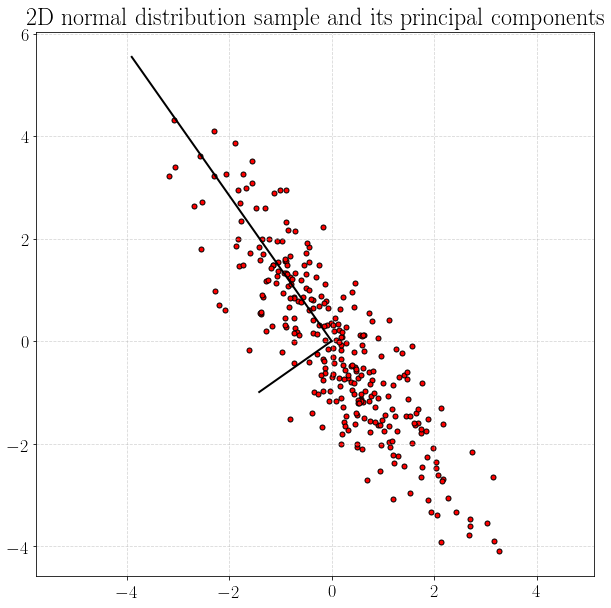

In [42]:
np.random.seed(0)
mean = np.array([0.0, 0.0])
cov  = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])
X = np.random.multivariate_normal(mean, cov, 300)

pca_version = 'sklearn' # 'sklearn'
pca = get_pca(pca_version)
pca.fit(X)

print('Proportion of variance explained by each component:\n' +\
      '1st component - %.2f,\n2nd component - %.2f\n' %
      tuple(pca.explained_variance_ratio_))
print('Directions of principal components:\n' +\
      '1st component:', pca.components_[0],
      '\n2nd component:', pca.components_[1])

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], s=25, c='r', marker='o', edgecolor='k')
for var_ratio, direction in zip(pca.explained_variance_ratio_, pca.components_):
    d = 7 * np.sqrt(var_ratio) * direction
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=2)
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.axis('equal')
plt.title('2D normal distribution sample and its principal components');

Первая главная компонента (ей соответствует более длинный вектор) объясняет более 90% дисперсии исходных данных. Это говорит о том, что она содержит в себе почти всю информацию о расположении выборки в пространстве, и вторая компонента может быть опущена. Спроецируем данные на первую компоненту.

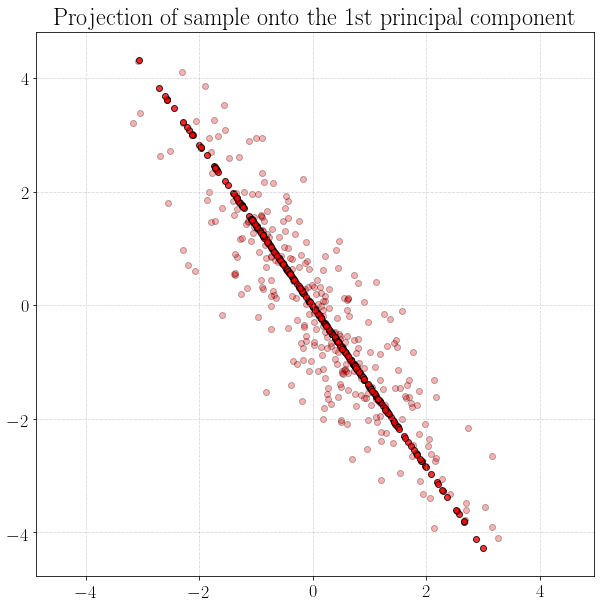

In [19]:
# Keep enough components to explain 90% of variance
pca = sklearn.decomposition.PCA(0.90)
X_reduced = pca.fit_transform(X)

# Map the reduced data into the initial feature space
X_new = pca.inverse_transform(X_reduced)

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, edgecolor='k', color='r')
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, edgecolor='k', color='r')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.axis('equal')
plt.title('Projection of sample onto the 1st principal component');

Размерность данных понижена двое при сохранении наиболее значимых черт. В этом заключается основной принцип понижения размерности кае метода приближения многомерных данных с помощью данных меньшей размерности, при сохранении как можно большей информации об исходных данных.

## Визуализация многомерных данных [[toc](#toc)]

Одним из применений метода главных компонент является визуализации многомерных данных в двухмерном (или трехмерном) пространстве. Для этого необходимо взять первые две главных компоненты и спроецировать данные на них. При этом, если признаки имеют различную природу, их следует отмасштабировать. Основные способы масштабирования:
- На единичную дисперсию по осям (масштабы по осям равны средним квадратичным отклонениям — после этого преобразования ковариационная матрица совпадает с матрицей коэффициентов корреляции).
- На равную точность измерения (масштаб по оси пропорционален точности измерения данной величины).
- На равные требования в задаче (масштаб по оси определяется требуемой точностью прогноза данной величины или допустимым её искажением — уровнем толерантности). 

<a id='pca_iris'></a>
## Пример с набором данных Iris [[toc](#toc)]

In [43]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target
print(X.shape, y.shape)

(150, 4) (150,)


Meaning of the 2 components:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


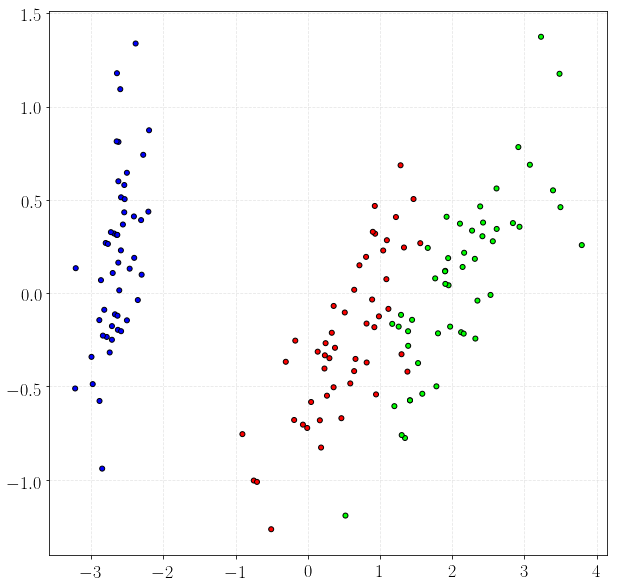

In [44]:
pca_version = 'my'
pca = get_pca(pca_version, n_components=2)
X_reduced = pca.fit_transform(X)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join('{:.3f} x {}'.format(value, name) for value, name in zip(component, iris.feature_names)))
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=25, cmap='brg', edgecolor='k', zorder=2)
plt.grid(which='both', alpha=0.3, linestyle='--');

<a id='pca_digits'></a>
## Пример с набором данных digits [[toc]](#toc)

Рассмотрим применение метода главных компонент для визуализации данных из набора изображений рукописных цифр.

In [45]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


### Визуализация

Projecting 64-dimensional data to 2D


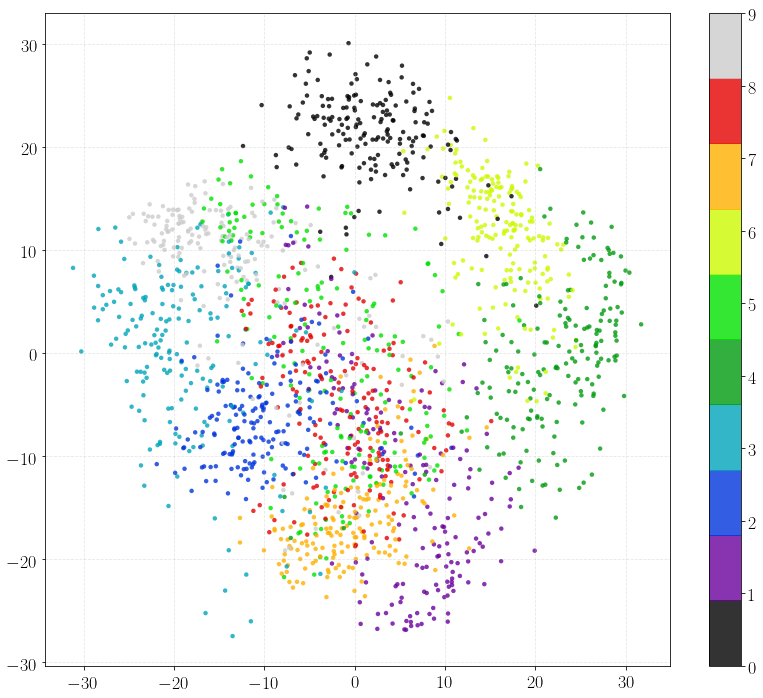

In [46]:
pca_version = 'scikit'
pca = get_pca(pca_version, n_components=2)
X_reduced = pca.fit_transform(X)

pca = get_pca(pca_version, n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting {}-dimensional data to 2D'.format(X.shape[1]))

plt.figure(figsize=(14, 12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.8, s=20,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.grid(which='both', alpha=0.3, linestyle='--');

Визуализация раскрывает определенные зависимости между цифрами:
* Цифры 0 и 6 располагаются в соседних кластерах, что говорит об их схожем написании.
* Наиболее "размытый" по другим кластерам --- это кластер, соответствующий цифре 8, что говорит о том, что она имеет много различных написаний, делающих её схожей со многими другими цифрами.

Посмотрим, как выглядят первые две главные компоненты.

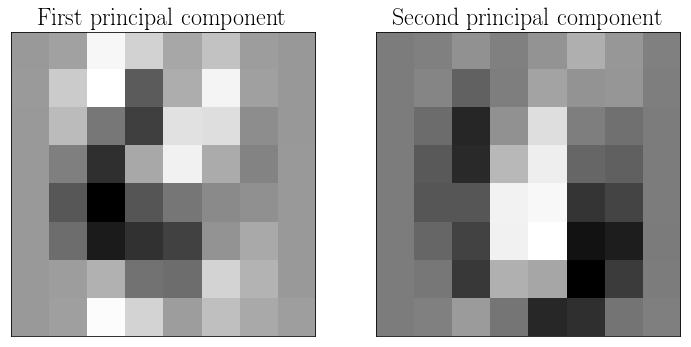

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

im = pca.components_[0]
ax1.imshow(im.reshape((8, 8)), cmap='binary', interpolation='none')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('First principal component')

im = pca.components_[1]
ax2.imshow(im.reshape((8, 8)), cmap='binary', interpolation='none')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Second principal component');

### Сжатие данных

Другим применением PCA является снижение размерности данных для их сжатия. Рассмотрим, как влияет число отбираемых главных компонент (на которые осуществляется проекция) на качество восстановления исходного изображения.

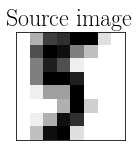

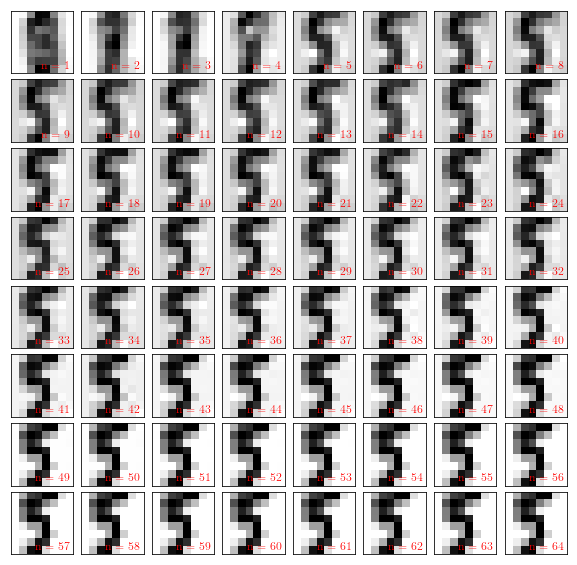

In [48]:
plt.figure(figsize=(4, 2))
plt.imshow(X[15].reshape((8, 8)), cmap='binary', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.title('Source image')
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    pca = sklearn.decomposition.PCA(i + 1).fit(X)
    im = pca.inverse_transform(pca.transform(X[15].reshape(1, -1)))

    ax.imshow(im.reshape((8, 8)), cmap='binary', interpolation='none')
    ax.text(0.95, 0.05, 'n = {0}'.format(i + 1), ha='right',
            transform=ax.transAxes, color='red')
    ax.set_xticks([])
    ax.set_yticks([])

Как понять, какое число главных компонент достаточно оставить? Для этого может оказаться полезным следующий график, выражающий зависимость общей доли объясняемой дисперсии от числа главных компонент.

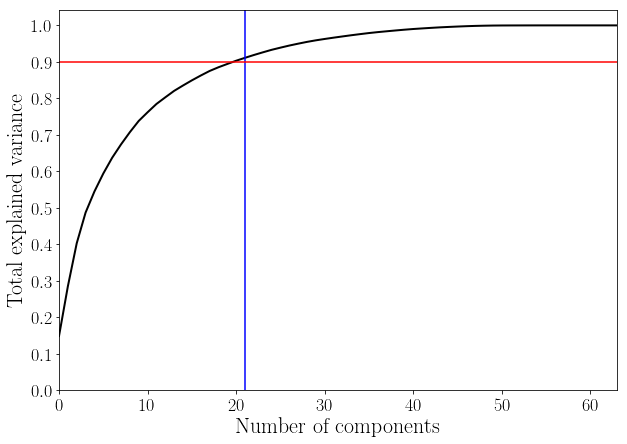

In [135]:
pca = sklearn.decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b');
plt.axhline(0.9, c='r');

In [136]:
pca = PCA(0.9).fit(X)
print('We need %d components to explain 90%% of variance' % pca.n_components_)

We need 21 components to explain 90% of variance
